boundary_targets shape: torch.Size([1, 1, 1080, 1920])
torch.Size([1, 1, 1080, 1920])


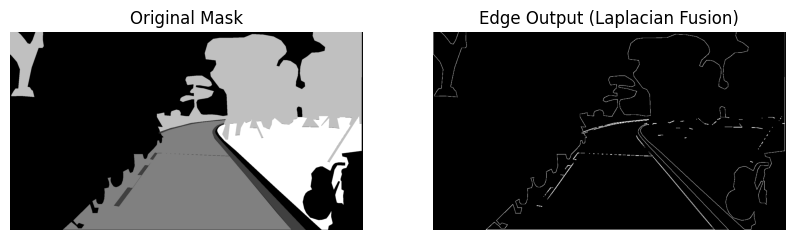

In [2]:

import torch
from torch import nn
from torch.nn import functional as F
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

class DetailAggregateLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(DetailAggregateLoss, self).__init__()

        self.laplacian_kernel = torch.tensor(
            [-1, -1, -1, -1, 8, -1, -1, -1, -1],
            dtype=torch.float32).reshape(1, 1, 3, 3).requires_grad_(False).type(torch.cuda.FloatTensor)

        self.fuse_kernel = torch.nn.Parameter(torch.tensor([[6./10], [3./10], [1./10]],
            dtype=torch.float32).reshape(1, 3, 1, 1).type(torch.cuda.FloatTensor))

    def forward(self, gtmasks):

        # boundary_logits = boundary_logits.unsqueeze(1)
        boundary_targets = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, padding=1)
        print("boundary_targets shape:", boundary_targets.shape)
        boundary_targets = boundary_targets.clamp(min=0)
        boundary_targets[boundary_targets > 0.1] = 1
        boundary_targets[boundary_targets <= 0.1] = 0

        boundary_targets_x2 = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, stride=2, padding=1)
        boundary_targets_x2 = boundary_targets_x2.clamp(min=0)

        boundary_targets_x4 = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, stride=4, padding=1)
        boundary_targets_x4 = boundary_targets_x4.clamp(min=0)

        boundary_targets_x8 = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, stride=8, padding=1)
        boundary_targets_x8 = boundary_targets_x8.clamp(min=0)

        boundary_targets_x8_up = F.interpolate(boundary_targets_x8, boundary_targets.shape[2:], mode='nearest')
        boundary_targets_x4_up = F.interpolate(boundary_targets_x4, boundary_targets.shape[2:], mode='nearest')
        boundary_targets_x2_up = F.interpolate(boundary_targets_x2, boundary_targets.shape[2:], mode='nearest')

        boundary_targets_x2_up[boundary_targets_x2_up > 0.1] = 1
        boundary_targets_x2_up[boundary_targets_x2_up <= 0.1] = 0

        boundary_targets_x4_up[boundary_targets_x4_up > 0.1] = 1
        boundary_targets_x4_up[boundary_targets_x4_up <= 0.1] = 0

        boundary_targets_x8_up[boundary_targets_x8_up > 0.1] = 1
        boundary_targets_x8_up[boundary_targets_x8_up <= 0.1] = 0

        boudary_targets_pyramids = torch.stack((boundary_targets, boundary_targets_x2_up, boundary_targets_x4_up), dim=1)

        boudary_targets_pyramids = boudary_targets_pyramids.squeeze(2)
        boudary_targets_pyramid = F.conv2d(boudary_targets_pyramids, self.fuse_kernel)

        boudary_targets_pyramid[boudary_targets_pyramid > 0.1] = 1
        boudary_targets_pyramid[boudary_targets_pyramid <= 0.1] = 0

        print(boudary_targets_pyramid.shape)

        return boudary_targets_pyramid


if __name__ == '__main__':

    # ============ Mask 路径 ============
    mask_path = "/home/only/workspace/wang/deeplearning/segment/BiseNetV2/datasets/test/labels/val/1_2025-05-30_2025-05-30_camera_camera_1748589624_744766.6365_2445242.9984_1.8636.png"

    # 读取 mask（灰度）
    mask_img = Image.open(mask_path).convert("L")
    mask_np = np.array(mask_img)

    # 转成 0/1 mask
    mask_bin = (mask_np > 0).astype(np.float32)

    # 转 tensor
    mask_tensor = torch.from_numpy(mask_bin).unsqueeze(0).cuda()

    # 前向
    dal = DetailAggregateLoss().cuda()
    with torch.no_grad():
        edge_output = dal(mask_tensor)

    edge_np = edge_output.squeeze().cpu().numpy()

    # ============================
    #        matplotlib 可视化
    # ============================
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.title("Original Mask")
    plt.imshow(mask_np, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Edge Output (Laplacian Fusion)")
    plt.imshow(edge_np, cmap='gray')
    plt.axis('off')
    plt.show()

In [4]:

import torch
from torch import nn
from torch.nn import functional as F
import cv2
import numpy as np
import json

def dice_loss_func(input, target):
    smooth = 1.
    n = input.size(0)
    iflat = input.view(n, -1)
    tflat = target.view(n, -1)
    intersection = (iflat * tflat).sum(1)
    loss = 1 - ((2. * intersection + smooth) /
                (iflat.sum(1) + tflat.sum(1) + smooth))
    return loss.mean()

def get_one_hot(label, N):
    size = list(label.size())
    label = label.view(-1)   # reshape 为向量
    ones = torch.sparse.torch.eye(N).cuda()
    ones = ones.index_select(0, label.long())   # 用上面的办法转为换one hot
    size.append(N)  # 把类别输目添到size的尾后，准备reshape回原来的尺寸
    return ones.view(*size)

def get_boundary(gtmasks):

    laplacian_kernel = torch.tensor(
        [-1, -1, -1, -1, 8, -1, -1, -1, -1],
        dtype=torch.float32, device=gtmasks.device).reshape(1, 1, 3, 3).requires_grad_(False)
    # boundary_logits = boundary_logits.unsqueeze(1)
    boundary_targets = F.conv2d(gtmasks.unsqueeze(1), laplacian_kernel, padding=1)
    boundary_targets = boundary_targets.clamp(min=0)
    boundary_targets[boundary_targets > 0.1] = 1
    boundary_targets[boundary_targets <= 0.1] = 0
    return boundary_targets


class DetailAggregateLoss(nn.Module):
    def __init__(self, *args, **kwargs):
        super(DetailAggregateLoss, self).__init__()
        
        self.laplacian_kernel = torch.tensor(
            [-1, -1, -1, -1, 8, -1, -1, -1, -1],
            dtype=torch.float32).reshape(1, 1, 3, 3).requires_grad_(False).type(torch.cuda.FloatTensor)
        
        self.fuse_kernel = torch.nn.Parameter(torch.tensor([[6./10], [3./10], [1./10]],
            dtype=torch.float32).reshape(1, 3, 1, 1).type(torch.cuda.FloatTensor))

    def forward(self, boundary_logits, gtmasks):

        # boundary_logits = boundary_logits.unsqueeze(1)
        boundary_targets = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, padding=1)
        boundary_targets = boundary_targets.clamp(min=0)
        boundary_targets[boundary_targets > 0.1] = 1
        boundary_targets[boundary_targets <= 0.1] = 0

        boundary_targets_x2 = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, stride=2, padding=1)
        boundary_targets_x2 = boundary_targets_x2.clamp(min=0)
        
        boundary_targets_x4 = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, stride=4, padding=1)
        boundary_targets_x4 = boundary_targets_x4.clamp(min=0)

        boundary_targets_x8 = F.conv2d(gtmasks.unsqueeze(1).type(torch.cuda.FloatTensor), self.laplacian_kernel, stride=8, padding=1)
        boundary_targets_x8 = boundary_targets_x8.clamp(min=0)
    
        boundary_targets_x8_up = F.interpolate(boundary_targets_x8, boundary_targets.shape[2:], mode='nearest')
        boundary_targets_x4_up = F.interpolate(boundary_targets_x4, boundary_targets.shape[2:], mode='nearest')
        boundary_targets_x2_up = F.interpolate(boundary_targets_x2, boundary_targets.shape[2:], mode='nearest')
        
        boundary_targets_x2_up[boundary_targets_x2_up > 0.1] = 1
        boundary_targets_x2_up[boundary_targets_x2_up <= 0.1] = 0
        
        
        boundary_targets_x4_up[boundary_targets_x4_up > 0.1] = 1
        boundary_targets_x4_up[boundary_targets_x4_up <= 0.1] = 0
       
        
        boundary_targets_x8_up[boundary_targets_x8_up > 0.1] = 1
        boundary_targets_x8_up[boundary_targets_x8_up <= 0.1] = 0
        
        boudary_targets_pyramids = torch.stack((boundary_targets, boundary_targets_x2_up, boundary_targets_x4_up), dim=1)
        
        boudary_targets_pyramids = boudary_targets_pyramids.squeeze(2)
        boudary_targets_pyramid = F.conv2d(boudary_targets_pyramids, self.fuse_kernel)

        boudary_targets_pyramid[boudary_targets_pyramid > 0.1] = 1
        boudary_targets_pyramid[boudary_targets_pyramid <= 0.1] = 0
        
        if boundary_logits.shape[-1] != boundary_targets.shape[-1]:
            boundary_logits = F.interpolate(
                boundary_logits, boundary_targets.shape[2:], mode='bilinear', align_corners=True)

        bce_loss = F.binary_cross_entropy_with_logits(boundary_logits, boudary_targets_pyramid)
        dice_loss = dice_loss_func(torch.sigmoid(boundary_logits), boudary_targets_pyramid)
        return bce_loss,  dice_loss

    def get_params(self):
        wd_params, nowd_params = [], []
        for name, module in self.named_modules():
                nowd_params += list(module.parameters())
        return nowd_params

# =======================
#     测试代码
# =======================
if __name__ == '__main__':

    # 随机生成 mask （B=1, H=512, W=512 的二值 mask）
    H, W = 512, 512
    gtmasks = torch.randint(0, 2, (1, H, W)).float().cuda()

    # 随机预测（boundary_logits）
    boundary_logits = torch.randn(1, 1, H, W).cuda()  # 随机模拟网络输出

    # 损失
    loss_fn = DetailAggregateLoss().cuda()

    bce_loss, dice_loss = loss_fn(boundary_logits, gtmasks)

    print("BCE Loss =", bce_loss.item())
    print("Dice Loss =", dice_loss.item())


BCE Loss = 0.8077503442764282
Dice Loss = 0.42215651273727417
